In [7]:
%load_ext autoreload
%autoreload 2 

from vpot.calc import myMolecule, sphericalGrid, blockGrid, pointGrid
from vpot.calc.potential import vpot,vBpot, vpotANC
from vpot.calc import DFTGroundState
from matplotlib import pyplot as plt
import psi4
import numpy as np
import logging,time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we inspect the GridError when calculating Matrix elements

In [2]:
maxDist = 10.0
Data = {}
for nSphere in [146,170,194,230,266,302,350,434,590,770,974,1202,1454,1730,2030]:
    Data[nSphere] = []
    for nRadial in [25,50,100,150,200,300]:
        M = myMolecule("tests/6-QM7/1.xyz","def2-TZVP")
        Gs = sphericalGrid(M,minDist=0.0,maxDist=maxDist,nRadial=nRadial,nSphere=nSphere,pruningScheme="None")   
        Vs = Gs.optimizeBasis()
                           
        vpotAnalytic = M.ao_pot
        vpotNumeric  = np.einsum("ji,j,jk,j->ik",Gs.phi,vpot(Gs.mol.geom,Gs.mol.elez,Gs.points),Gs.phi,Gs.weights,optimize=True)
        
        Data[nSphere].append([nRadial,np.max(np.abs(vpotAnalytic-vpotNumeric)),np.linalg.norm(vpotAnalytic-vpotNumeric)])

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 

BASIS SET WAS AUGMENTED!! In Total now 88 functions

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 

BASIS SET WAS AUGMENTED!! In Total now 88 functions

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.


KeyboardInterrupt



In [ ]:
for i in Data.keys():
    plt.plot([x[0] for x in Data[i]],[x[1] for x in Data[i]],label=str(i))
plt.legend()
plt.yscale("log")
plt.xlabel("nRadial")
#plt.ylim(1E-7,1E-5)
plt.hlines(1E-6,0,300)

Here we have a look at the residue, which can
descrease the ANC error.

In [10]:
maxDist = 10.0
nSphere = 590
nRadial = 300
prec = 4

Data = {}
#for nSphere in [146,170,194,230,266,302,350,434,590,770,974,1202,1454,1730,2030]:
Data[nSphere] = []
#    for nRadial in [25,50,100,150,200,300]:
M = myMolecule("tests/6-QM7/1.xyz","def2-TZVP-decon")
Gs = sphericalGrid(M,minDist=0.0,maxDist=maxDist,nRadial=nRadial,nSphere=nSphere,pruningScheme="None")   
Vs = Gs.optimizeBasis()
                           
vpotAnalytic = M.ao_pot
vpotNumeric  = np.einsum("ji,j,jk,j->ik",Gs.phi,vpot(Gs.mol.geom,Gs.mol.elez,Gs.points),Gs.phi,Gs.weights,optimize=True)
ANCexact     = np.einsum("ji,j,jk,j->ik",Gs.phi,vpotANC(M.geom,M.elez,Gs.points,prec),Gs.phi,Gs.weights,optimize=True)

R = vpot(Gs.mol.geom,Gs.mol.elez,Gs.points) - vpotANC(M.geom,M.elez,Gs.points,prec)

ANCexact2 = np.einsum("ji,j,jk,j->ik",Gs.phi,vpotANC(M.geom,M.elez,Gs.points,prec)+R,Gs.phi,Gs.weights,optimize=True)
Vs = Gs.optimizeBasis(potentialType="anc",a=prec)

ANCbasis =  np.einsum("ji,j,jk,j->ik",Gs.phi,vBpot(Gs.phi,Vs.diagonal()),Gs.phi,Gs.weights,optimize=True)


Data[nSphere].append([nRadial,np.max(np.abs(vpotAnalytic-vpotNumeric)),np.linalg.norm(vpotAnalytic-vpotNumeric)])

print(f"ANCerror: {np.linalg.norm(ANCexact-vpotAnalytic)} ")
print(f"ANCerror2: {np.linalg.norm(ANCexact2-vpotAnalytic)} ")
print(f"GridErr : {np.linalg.norm(vpotNumeric-vpotAnalytic)}")
print(f"BasisErr: {np.linalg.norm(ANCexact-ANCbasis)}")


   => Loading Basis Set <=

    Name: DEF2-TZVP-DECON
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs func decontract
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs func decontract

ANCerror: 928.5525140932147 
ANCerror2: 0.0010852782907369589 
GridErr : 0.0010852782907241059
BasisErr: 2.0163699173703242


GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 10.0, 'nRadical': 300, 'nSphere': 590, 'nPoints': 1120623, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 9578585.826037535
MeanError: 8.547554196226148
MaxError : 935.3000771870365
MinError : 1.8077998568408652e-12


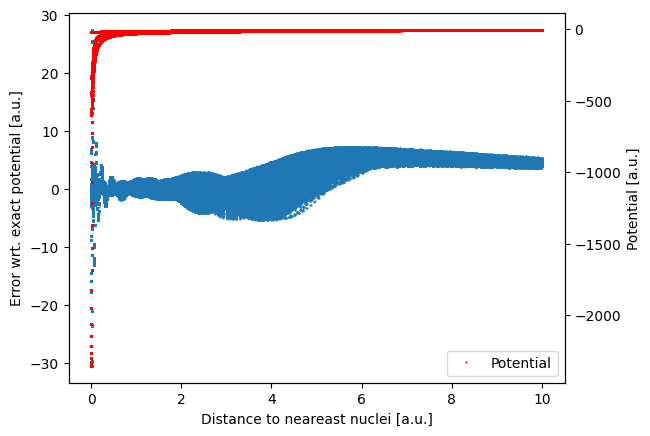

In [9]:
Gs.printStats(Vs,output="print")
Gs.exportErrorVsDistance(Vs,plotPot=True)

   => Loading Basis Set <=

    Name: DEF2-QZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   194 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvp.gbs 
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-qzvp.gbs 

BASIS SET WAS AUGMENTED!!

GridInfo : {'type': 'block', 'minDist': 0.0, 'nPoints': 327520, 'block': {'xmin': -1.8177640544877172, 'xmax': 6.957875467366071, 'ymin': -4.001080619721465, 'ymax': 4.947985455939891, 'zmin': -4.716968326828797, 'zmax': 4.665812873694817}, 'xdim': 88, 'ydim': 90, 'zdim': 94} 
residue  : 477.8873809911462
MeanError: 0.0014591090040032553
MaxError : 67.66854121353639
MinError : 5.4941312015337655e-15


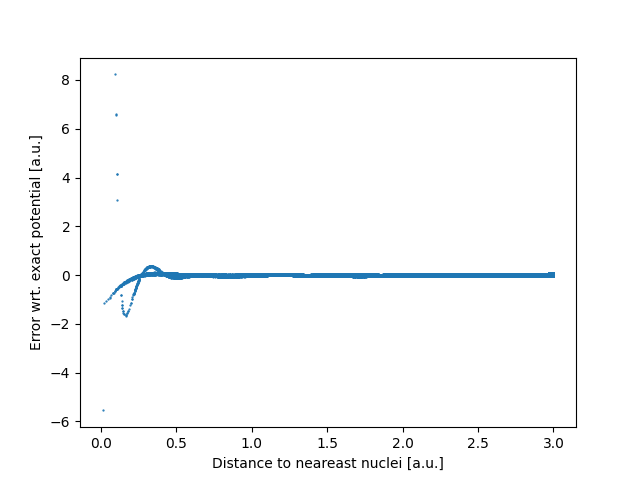

(-300.0, 100.0)

In [42]:
maxDist = 10.0
nSphere = 590
nRadial = 300
prec = 1


M = myMolecule("tests/6-QM7/1.xyz","def2-QZVP")
Gb = blockGrid(M,minDist=0.0,maxDist=3.0,gridSpacing=0.1)
Vb = Gb.optimizeBasis(potentialType="anc",a=prec)
Gb.printStats(Vb,output="print")
Gb.exportErrorVsDistance(Vb)

P1 = M.geom[0]
P2 = M.geom[2]
v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.05,0.01)

L = np.array([P1 + i*v for i in r])
VPOT = vpot(Gb.mol.geom,Gb.mol.elez,L)
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,L,3)
GL = pointGrid(M,L)
VBAS = vBpot(GL.phi,Vb.diagonal())

plt.plot(VPOT)
plt.plot(VANC)
plt.plot(VBAS)

plt.ylim(-300,100)

Let's try again a spherical grid

   => Loading Basis Set <=

    Name: DEF2-SVP-DECON
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line    90 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs func decontract
    atoms 2-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-svp.gbs func decontract

GridInfo : {'type': 'spherical', 'minDist': 0.1, 'maxDist': 5.0, 'nRadical': 75, 'nSphere': 302, 'nPoints': 37332, 'radialScheme': 'BECKE', 'pruningScheme': 'TREUTLER'} 
residue  : 746.721655372046
MeanError: 0.020002187275582502
MaxError : 1.7042546446574567
MinError : 2.570218695400275e-12


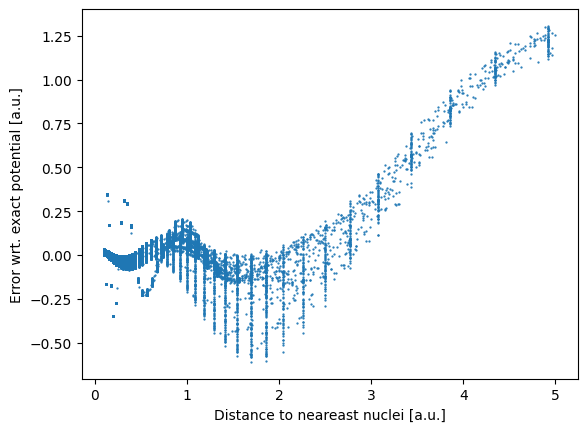

(-300.0, 100.0)

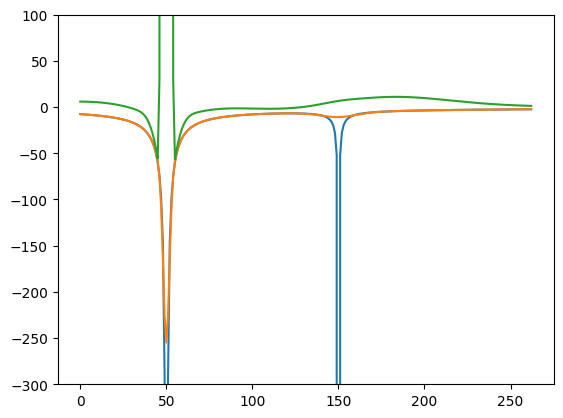

In [140]:
maxDist = 10.0
nSphere = 590
nRadial = 300
prec = 1


M = myMolecule("tests/6-QM7/1.xyz","def2-SVP-decon")
Gs = sphericalGrid(M,minDist=0.0,maxDist=5.0)
Vs = Gs.optimizeBasis(potentialType="anc",a=prec)
Gs.printStats(Vs,output="print")
Gs.exportErrorVsDistance(Vs)

P1 = M.geom[0]
P2 = M.geom[2]
v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.05,0.01)

L = np.array([P1 + i*v for i in r])
VPOT = vpot(Gs.mol.geom,Gs.mol.elez,L)
VANC = vpotANC(Gs.mol.geom,Gs.mol.elez,L,3)
GL = pointGrid(M,L)
VBAS = vBpot(GL.phi,Vs.diagonal())

plt.plot(VPOT)
plt.plot(VANC)
plt.plot(VBAS)

plt.ylim(-300,100)

Spherical grid and weights 

   => Loading Basis Set <=

    Name: DEF2-TZVP
    Role: ORBITAL
    Keyword: BASIS
    atoms 1   entry C          line   123 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 2   entry CL         line   534 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 
    atoms 3-5 entry H          line    15 file /media/miniconda3/envs/vpot/share/psi4/basis/def2-tzvp.gbs 


BASIS SET WAS AUGMENTED!! In Total now 122 functions

Filter: (695515, 4)
GridInfo : {'type': 'spherical', 'minDist': 0.0, 'maxDist': 7.5, 'nRadical': 300, 'nSphere': 590, 'nPoints': 695515, 'radialScheme': 'BECKE', 'pruningScheme': 'None'} 
residue  : 787011.1193192276
MeanError: 1.1315516118548523
MaxError : 14.517669547986456
MinError : 6.540424042299272e-14


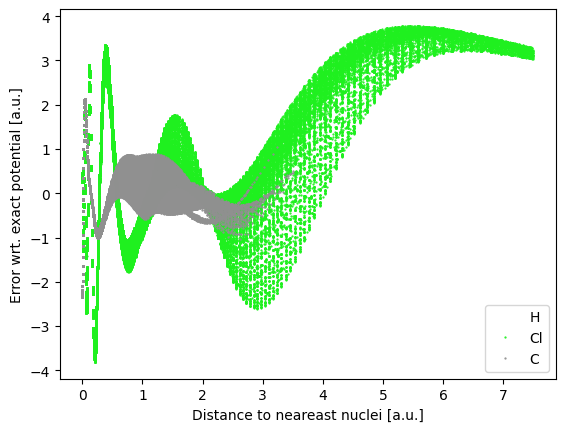

(-60.0, 10.0)

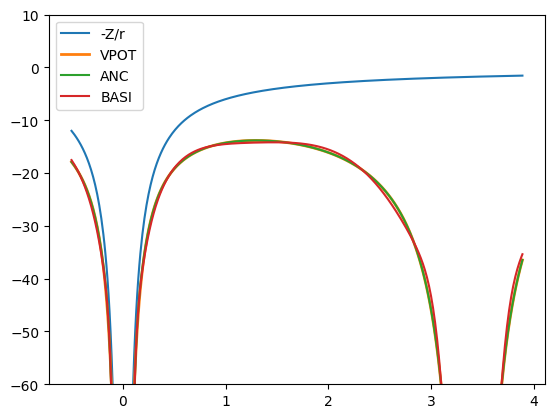

In [10]:
maxDist = 10.0
nSphere = 590
nRadial = 300
prec = 2


M = myMolecule("tests/CH3Cl.xyz","def2-TZVP",augmentBasis=True)
Gs = sphericalGrid(M,minDist=0.0,maxDist=7.5,nSphere=nSphere,nRadial=nRadial,pruningScheme="None")

Vs = Gs.optimizeBasis(potentialType="anc",a=prec)
Gs.printStats(Vs,output="print")
Gs.exportErrorVsDistance(Vs)

P1 = M.geom[0]
P2 = M.geom[1]
v = P2-P1
r = np.arange(-0.5,np.linalg.norm(v)+0.5,0.01)

L = np.array([P1 + i*v/np.linalg.norm(v) for i in r])
VPOT = vpot(Gs.mol.geom,Gs.mol.elez,L)
VANC = vpotANC(Gs.mol.geom,Gs.mol.elez,L,prec)
GL = pointGrid(M,L)
VBAS = vBpot(GL.phi,Vs.diagonal())

plt.plot(r,vpot([Gs.mol.geom[0]],[Gs.mol.elez[0]],L),label="-Z/r")

plt.plot(r,VPOT,label="VPOT",lw=2)
plt.plot(r,VANC,label="ANC")
plt.plot(r,VBAS,label="BASI")

plt.legend()
plt.ylim(-60,10)



In [23]:
np.linalg.norm(M.geom[0] - M.geom[1]

2.888812114529724

In [65]:
VPOT = vpot(Gb.mol.geom,Gb.mol.elez,Gb.points[100:200])
VANC = vpotANC(Gb.mol.geom,Gb.mol.elez,Gb.points[100:200],a=2)


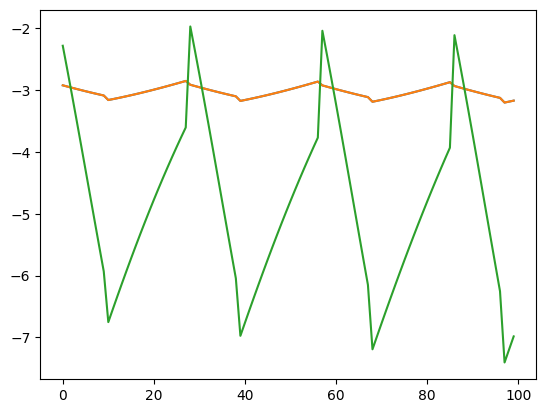

In [66]:
plt.plot(VPOT)
plt.plot(VANC)
GL = pointGrid(M,Gb.points[100:200])
VBAS = vBpot(GL.phi,Vb.diagonal())
plt.plot(VBAS)

In [67]:
VBAS

array([-2.2824323 , -2.67156429, -3.06855748, -3.47189983, -3.88000964,
       -4.2912493 , -4.70393995, -5.11637677, -5.52684468, -5.93363411,
       -6.75337502, -6.54193987, -6.33282815, -6.12636401, -5.9228315 ,
       -5.72247403, -5.52549439, -5.33205558, -5.1422823 , -4.95626324,
       -4.77405403, -4.59568091, -4.42114483, -4.25042605, -4.08348889,
       -3.92028662, -3.76076619, -3.60487271, -1.97060885, -2.35444497,
       -2.74766423, -3.14882718, -3.5564111 , -3.96882283, -4.38441256,
       -4.80148862, -5.21833287, -5.6332165 , -6.04441596, -6.97522506,
       -6.76356861, -6.55389302, -6.34649585, -6.1416382 , -5.93954471,
       -5.74040422, -5.54437089, -5.35156609, -5.16208079, -4.97597861,
       -4.7932993 , -4.61406266, -4.43827275, -4.2659222 , -4.09699652,
       -3.93147819, -3.76935046, -2.04019665, -2.42754259, -2.8243461 ,
       -3.22916049, -3.64045514, -4.05662825, -4.47602081, -4.89693138,
       -5.31763155, -5.73638188, -6.1514479 , -7.19340531, -6.98